# CNN + Masks (UNET)

This notebook uses the model from 
https://ieeexplore.ieee.org/abstract/document/9057809

In addition we add segmentation masks from unet to a 4. channel of the images.
The input is therefore R - G - B - Cutout (grayscale img).

In [1]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from generators import MaskPredDataGenerator

In [2]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS=1
USE_MASKS=False
MODELSAVE = "models/cnn_gray_030121"

if(USE_MASKS):
    MODELSAVE += "_w_masks.h5"
else:
    MODELSAVE += "_wo_masks.h5"


train_path = '/home/8cb7/.kaggle/mooney/chest_xray/train/'
test_path = '/home/8cb7/.kaggle/mooney/chest_xray/test/'
val_path = '/home/8cb7/.kaggle/mooney/chest_xray/val/'

train_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/train/'
val_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/val/'
test_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/test/'

# covid19
covid_path = '/home/8cb7/.kaggle/covid-chestxray-dataset/output'
covid_mask_path = '/home/8cb7/.kaggle/covid-chestxray-dataset/masks/'

In [3]:
USE_MASKS

False

In [4]:
np.random.seed(200)
tf.random.set_seed(200)

## 1 Data preparation

In [5]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]

            mask_path = None
            if masks_folder is not None:
                mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            label2 = '-'
            if img_path is not None:
                if label_folder != 'NORMAL':
                    label2 = filename_wo_ending.split("_")[1].split("_")[0]

                tmp_df = tmp_df.append({'img': img_path, 'mask': mask_path, 'label': label_folder, 'label2': label2, 'label3': '-'}, ignore_index=True)

    return tmp_df

In [6]:
def load_covid_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    for filename in os.listdir(img_folder):
        img_path = str(img_folder)+'/'+str(filename)
        label = 'PNEUMONIA' # virurs => covid19
        # normal file ending is jpEg...
        filename_wo_ending = filename.rsplit('.')[0]
        mask_path = str(masks_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'
        if img_path is not None:
            tmp_df = tmp_df.append({'img': img_path,  'mask': mask_path, 'label': label, 'label2': 'virus', 'label3': 'covid19'}, ignore_index=True)

    return tmp_df

In [7]:
df_train = load_images_from_folder(train_path, train_mask_path)
df_val = load_images_from_folder(val_path, val_mask_path)
df_test = load_images_from_folder(test_path, test_mask_path)
df_covid = load_covid_images_from_folder(covid_path, covid_mask_path)

In [8]:
df_train.shape

(5216, 5)

In [9]:
df_train = df_train.append(df_val, ignore_index=True) # append val to train since we are using k-fold cv

In [10]:
df_train.shape

(5232, 5)

In [11]:
df_covid.head()

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/covid-chestxray-dataset/out...,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/mas...,virus,covid19
1,/home/8cb7/.kaggle/covid-chestxray-dataset/out...,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/mas...,virus,covid19
2,/home/8cb7/.kaggle/covid-chestxray-dataset/out...,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/mas...,virus,covid19
3,/home/8cb7/.kaggle/covid-chestxray-dataset/out...,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/mas...,virus,covid19
4,/home/8cb7/.kaggle/covid-chestxray-dataset/out...,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/mas...,virus,covid19


In [12]:
# Split covid19 data
from sklearn.model_selection import train_test_split
df_train_covid, df_test_covid = train_test_split(df_covid, test_size=0.1, random_state=200)
df_train_covid, df_val_covid = train_test_split(df_train_covid, test_size=0.2, random_state=200)

In [13]:
print('=== Covid Data: ===')
print('Train:', len(df_train_covid))
print('Val:', len(df_val_covid))
print('Test:', len(df_test_covid))

=== Covid Data: ===
Train: 140
Val: 36
Test: 20


In [14]:
pd.set_option('display.max_colwidth', -1)
df_train_covid

<ipython-input-14-b52841ad0c0e>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,img,label,mask,label2,label3
163,/home/8cb7/.kaggle/covid-chestxray-dataset/output/1-s2.0-S1684118220300682-main.pdf-002-a2.png,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//1-s2_predmask.jpg,virus,covid19
191,/home/8cb7/.kaggle/covid-chestxray-dataset/output/a8ac1969.jpg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//a8ac1969_predmask.jpg,virus,covid19
28,/home/8cb7/.kaggle/covid-chestxray-dataset/output/16663_1_1.jpg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//16663_1_1_predmask.jpg,virus,covid19
97,/home/8cb7/.kaggle/covid-chestxray-dataset/output/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//1312A392-67A3-4EBF-9319-810CF6DA5EF6_predmask.jpg,virus,covid19
9,/home/8cb7/.kaggle/covid-chestxray-dataset/output/covid-19-pneumonia-14-PA.png,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//covid-19-pneumonia-14-PA_predmask.jpg,virus,covid19
...,...,...,...,...,...
146,/home/8cb7/.kaggle/covid-chestxray-dataset/output/tpmd200203f2-c.png,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//tpmd200203f2-c_predmask.jpg,virus,covid19
108,/home/8cb7/.kaggle/covid-chestxray-dataset/output/covid-19-pneumonia-15-PA.jpg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//covid-19-pneumonia-15-PA_predmask.jpg,virus,covid19
44,/home/8cb7/.kaggle/covid-chestxray-dataset/output/AR-2.jpg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//AR-2_predmask.jpg,virus,covid19
72,/home/8cb7/.kaggle/covid-chestxray-dataset/output/f8335316.jpg,PNEUMONIA,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//f8335316_predmask.jpg,virus,covid19


In [15]:
df_train_covid = df_train_covid.append(df_val_covid, ignore_index=True) # append val to train since we are using k-fold cv

In [16]:
# Append Covid19 data to rest
df_train = df_train.append(df_train_covid, ignore_index=True)
df_val = df_val.append(df_val_covid, ignore_index=True)
df_test = df_test.append(df_test_covid, ignore_index=True)

In [17]:
print('=== Train Data: ===')
print('Normal:', len(df_train[df_train['label'] == 'NORMAL']))
print('Pneumonia:', len(df_train[df_train['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_train[df_train['label2'] == 'bacteria']))
print('|---> Viral:', len(df_train[df_train['label2'] == 'virus']))
print('    |---> Covid:', len(df_train[df_train['label3'] == 'covid19']))

=== Train Data: ===
Normal: 1349
Pneumonia: 4059
|---> Bacterial: 2538
|---> Viral: 1521
    |---> Covid: 176


In [18]:
print('=== Test Data: ===')
print('Normal:', len(df_test[df_test['label'] == 'NORMAL']))
print('Pneumonia:', len(df_test[df_test['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_test[df_test['label2'] == 'bacteria']))
print('|---> Viral:', len(df_test[df_test['label2'] == 'virus']))
print('    |---> Covid:', len(df_test[df_test['label3'] == 'covid19']))

=== Test Data: ===
Normal: 234
Pneumonia: 410
|---> Bacterial: 242
|---> Viral: 168
    |---> Covid: 20


In [19]:
print('=== Val Data: ===')
print('Normal:', len(df_val[df_val['label'] == 'NORMAL']))
print('Pneumonia:', len(df_val[df_val['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_val[df_val['label2'] == 'bacteria']))
print('|---> Viral:', len(df_val[df_val['label2'] == 'virus']))
print('    |---> Covid:', len(df_val[df_val['label3'] == 'covid19']))

=== Val Data: ===
Normal: 8
Pneumonia: 44
|---> Bacterial: 8
|---> Viral: 36
    |---> Covid: 36


In [20]:
# Shuffle
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)

In [21]:
def replace_by_binary_class(df, to_replace, value):
    return df.replace(to_replace=to_replace, value=value)

In [22]:
df_train = replace_by_binary_class(df_train, 'NORMAL', 0)
df_train = replace_by_binary_class(df_train, 'PNEUMONIA', 1)

df_val = replace_by_binary_class(df_val, 'NORMAL', 0)
df_val = replace_by_binary_class(df_val, 'PNEUMONIA', 1)

df_test = replace_by_binary_class(df_test, 'NORMAL', 0)
df_test = replace_by_binary_class(df_test, 'PNEUMONIA', 1)

In [23]:
df_train.head()

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1193_virus_2034.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1193_virus_2034_predmask.jpg,virus,-
1,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person458_bacteria_1952.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person458_bacteria_1952_predmask.jpg,bacteria,-
2,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/NORMAL2-IM-0386-0001_predmask.jpg,-,-
3,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person262_virus_545.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person262_virus_545_predmask.jpg,virus,-
4,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1188_virus_2024_predmask.jpg,virus,-



## 2 Data generator

In [24]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [25]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [26]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

class TrainDataGenerator4Channels(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
            img = img.reshape(img.shape[0], img.shape[1],1)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else: 
                # img_grayscaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = cv2.threshold(mask,0,1,cv2.THRESH_BINARY)[1]
                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                try:
                    mask = mask.reshape(IMG_SIZE,IMG_SIZE,1)
                except:
                    print("i", i)
                    print(str(X_mask_paths.iloc[batch[i]]))
                cutout_img = img * mask
                cutout_img = cutout_img.reshape(IMG_SIZE,IMG_SIZE,1)

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])
                mask = mask / 255.0

            # normalize
            img = img / 255.0

            X_imgs.append(img)

        return X_imgs, Y

## 3 Model training

In [27]:
def getModel():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name="db_dense1024"))
    model.add(Dense(512, activation='relu', name="db_dense512"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [28]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight


In [29]:
kf5 = StratifiedKFold(n_splits=5)

In [30]:
df_train.head()

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1193_virus_2034.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1193_virus_2034_predmask.jpg,virus,-
1,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person458_bacteria_1952.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person458_bacteria_1952_predmask.jpg,bacteria,-
2,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/NORMAL2-IM-0386-0001_predmask.jpg,-,-
3,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person262_virus_545.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person262_virus_545_predmask.jpg,virus,-
4,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1188_virus_2024_predmask.jpg,virus,-


In [31]:
kf5.split(df_train, df_train.label)
histories = []
run = 1

In [32]:
df_train

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1193_virus_2034.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1193_virus_2034_predmask.jpg,virus,-
1,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person458_bacteria_1952.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person458_bacteria_1952_predmask.jpg,bacteria,-
2,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/NORMAL2-IM-0386-0001_predmask.jpg,-,-
3,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person262_virus_545.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person262_virus_545_predmask.jpg,virus,-
4,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1188_virus_2024_predmask.jpg,virus,-
...,...,...,...,...,...
5403,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person23_bacteria_90.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person23_bacteria_90_predmask.jpg,bacteria,-
5404,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1030_virus_1722.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1030_virus_1722_predmask.jpg,virus,-
5405,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person885_bacteria_2809.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person885_bacteria_2809_predmask.jpg,bacteria,-
5406,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/IM-0359-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/IM-0359-0001_predmask.jpg,-,-


In [33]:
df_train.label.value_counts()

1    4059
0    1349
Name: label, dtype: int64

In [34]:
df_train

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1193_virus_2034.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1193_virus_2034_predmask.jpg,virus,-
1,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person458_bacteria_1952.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person458_bacteria_1952_predmask.jpg,bacteria,-
2,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/NORMAL2-IM-0386-0001_predmask.jpg,-,-
3,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person262_virus_545.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person262_virus_545_predmask.jpg,virus,-
4,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1188_virus_2024_predmask.jpg,virus,-
...,...,...,...,...,...
5403,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person23_bacteria_90.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person23_bacteria_90_predmask.jpg,bacteria,-
5404,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person1030_virus_1722.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person1030_virus_1722_predmask.jpg,virus,-
5405,/home/8cb7/.kaggle/mooney/chest_xray/train/PNEUMONIA/person885_bacteria_2809.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/PNEUMONIA/person885_bacteria_2809_predmask.jpg,bacteria,-
5406,/home/8cb7/.kaggle/mooney/chest_xray/train/NORMAL/IM-0359-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/train/NORMAL/IM-0359-0001_predmask.jpg,-,-


In [35]:
from sklearn.metrics import f1_score

In [36]:
run = 1
for train_index, val_index in kf5.split(df_train, df_train.label):
    print("Fold Nr.: ", run)
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_train.reset_index(drop=True, inplace=True)
    df_fold_val.reset_index(drop=True, inplace=True)
    
    
    print('=== Train Data: ===')
    print('Normal:', len(df_fold_train[df_fold_train['label'] == 0]))
    print('Pneumonia:', len(df_fold_train[df_fold_train['label'] == 1]))
    print('|---> Bacterial:', len(df_fold_train[df_fold_train['label2'] == 'bacteria']))
    print('|---> Viral:', len(df_fold_train[df_fold_train['label2'] == 'virus']))
    print('    |---> Covid:', len(df_fold_train[df_fold_train['label3'] == 'covid19']))
    
    print('=== Val Data: ===')
    print('Normal:', len(df_fold_val[df_fold_val['label'] == 0]))
    print('Pneumonia:', len(df_fold_val[df_fold_val['label'] == 1]))
    print('|---> Bacterial:', len(df_fold_val[df_fold_val['label2'] == 'bacteria']))
    print('|---> Viral:', len(df_fold_val[df_fold_val['label2'] == 'virus']))
    print('    |---> Covid:', len(df_fold_val[df_fold_val['label3'] == 'covid19']))
    
    train_generator = TrainDataGenerator4Channels(df_fold_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, useMasks=USE_MASKS)
    val_generator = TrainDataGenerator4Channels(df_fold_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    

    # Adjust class_weights since we're dealing with imbalanced data here
    class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label']), df_fold_train['label'])
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    print("Class weights: ", class_weights)
    model = getModel()
    history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    class_weight=class_weights,
                    #callbacks=[mcp_save, learning_rate_reduction], # learning_rate_reduction]],
                    verbose = True)
    predictions = model.predict(val_generator)
    y_pred = predictions > 0.5
    print("F1: ", f1_score(df_fold_val.label, y_pred))
    histories.append(history)
    
    run += 1

Fold Nr.:  1
=== Train Data: ===
Normal: 1079
Pneumonia: 3247
|---> Bacterial: 2042
|---> Viral: 1205
    |---> Covid: 138
=== Val Data: ===
Normal: 270
Pneumonia: 812
|---> Bacterial: 496
|---> Viral: 316
    |---> Covid: 38
Class weights:  {0: 2.004633920296571, 1: 0.6661533723437019}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       1
3       1
4       1
       ..
4321    1
4322    1
4323    1
4324    0
4325    1
Name: label, Length: 4326, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/5
136/136 [==============================] - 35s 255ms/step - loss: 0.6501 - accuracy: 0.5888 - val_loss: 0.3719 - val_accuracy: 0.8678
Epoch 2/5
136/136 [==============================] - 34s 252ms/step - loss: 0.3985 - accuracy: 0.8243 - val_loss: 0.1858 - val_accuracy: 0.9214
Epoch 3/5
136/136 [==============================] - 35s 254ms/step - loss: 0.3349 - accuracy: 0.8590 - val_loss: 0.1478 - val_accuracy: 0.9409
Epoch 4/5
136/136 [==============================] - 34s 253ms/step - loss: 0.3256 - accuracy: 0.8588 - val_loss: 0.1273 - val_accuracy: 0.9492
Epoch 5/5
136/136 [==============================] - 34s 253ms/step - loss: 0.2900 - accuracy: 0.8807 - val_loss: 0.1474 - val_accuracy: 0.9390
F1:  0.9582278481012658
Fold Nr.:  2
=== Train Data: ===
Normal: 1079
Pneumonia: 3247
|---> Bacterial: 2035
|---> Viral: 1212
    |---> Covid: 142
=== Val Data: ===
Normal: 270
Pneumonia: 812
|---> Bacterial: 503
|---> Viral: 309
    |---> Covid: 34
Class weights:  {0: 2.00463392

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       0
3       1
4       1
       ..
4321    1
4322    1
4323    1
4324    0
4325    1
Name: label, Length: 4326, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/5
136/136 [==============================] - 35s 256ms/step - loss: 0.6661 - accuracy: 0.5659 - val_loss: 0.5210 - val_accuracy: 0.8216
Epoch 2/5
136/136 [==============================] - 34s 253ms/step - loss: 0.4186 - accuracy: 0.8135 - val_loss: 0.2798 - val_accuracy: 0.8734
Epoch 3/5
136/136 [==============================] - 34s 252ms/step - loss: 0.3231 - accuracy: 0.8558 - val_loss: 0.2270 - val_accuracy: 0.9067
Epoch 4/5
136/136 [==============================] - 35s 254ms/step - loss: 0.2922 - accuracy: 0.8812 - val_loss: 0.2010 - val_accuracy: 0.9196
Epoch 5/5
136/136 [==============================] - 34s 253ms/step - loss: 0.2520 - accuracy: 0.8923 - val_loss: 0.1931 - val_accuracy: 0.9233
F1:  0.9467607440667093
Fold Nr.:  3
=== Train Data: ===
Normal: 1079
Pneumonia: 3247
|---> Bacterial: 2039
|---> Viral: 1208
    |---> Covid: 146
=== Val Data: ===
Normal: 270
Pneumonia: 812
|---> Bacterial: 499
|---> Viral: 313
    |---> Covid: 30
Class weights:  {0: 2.00463392

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       0
3       1
4       1
       ..
4321    1
4322    1
4323    1
4324    0
4325    1
Name: label, Length: 4326, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/5
136/136 [==============================] - 35s 255ms/step - loss: 0.6813 - accuracy: 0.5132 - val_loss: 0.5382 - val_accuracy: 0.8891
Epoch 2/5
136/136 [==============================] - 34s 253ms/step - loss: 0.4676 - accuracy: 0.7755 - val_loss: 0.1909 - val_accuracy: 0.9353
Epoch 3/5
136/136 [==============================] - 35s 256ms/step - loss: 0.3415 - accuracy: 0.8532 - val_loss: 0.1904 - val_accuracy: 0.9288
Epoch 4/5
136/136 [==============================] - 35s 256ms/step - loss: 0.2874 - accuracy: 0.8800 - val_loss: 0.1450 - val_accuracy: 0.9501
Epoch 5/5
136/136 [==============================] - 35s 254ms/step - loss: 0.2568 - accuracy: 0.8957 - val_loss: 0.1124 - val_accuracy: 0.9621
F1:  0.9747692307692308
Fold Nr.:  4
=== Train Data: ===
Normal: 1080
Pneumonia: 3247
|---> Bacterial: 2005
|---> Viral: 1242
    |---> Covid: 141
=== Val Data: ===
Normal: 269
Pneumonia: 812
|---> Bacterial: 533
|---> Viral: 279
    |---> Covid: 35
Class weights:  {0: 2.00324074

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       0
3       1
4       1
       ..
4322    1
4323    1
4324    1
4325    0
4326    1
Name: label, Length: 4327, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/5
136/136 [==============================] - 35s 257ms/step - loss: 0.6498 - accuracy: 0.6214 - val_loss: 0.3685 - val_accuracy: 0.8816
Epoch 2/5
136/136 [==============================] - 34s 251ms/step - loss: 0.4241 - accuracy: 0.8135 - val_loss: 0.2166 - val_accuracy: 0.9149
Epoch 3/5
136/136 [==============================] - 35s 256ms/step - loss: 0.3312 - accuracy: 0.8616 - val_loss: 0.2850 - val_accuracy: 0.8899
Epoch 4/5
136/136 [==============================] - 35s 257ms/step - loss: 0.3007 - accuracy: 0.8736 - val_loss: 0.1334 - val_accuracy: 0.9454
Epoch 5/5
136/136 [==============================] - 35s 255ms/step - loss: 0.2598 - accuracy: 0.8858 - val_loss: 0.1808 - val_accuracy: 0.9306
F1:  0.9518922386144966
Fold Nr.:  5
=== Train Data: ===
Normal: 1079
Pneumonia: 3248
|---> Bacterial: 2031
|---> Viral: 1217
    |---> Covid: 137
=== Val Data: ===
Normal: 270
Pneumonia: 811
|---> Bacterial: 507
|---> Viral: 304
    |---> Covid: 39
Class weights:  {0: 2.00509731

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2       0
3       1
4       1
       ..
4322    1
4323    1
4324    1
4325    1
4326    1
Name: label, Length: 4327, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/5
136/136 [==============================] - 35s 259ms/step - loss: 0.6665 - accuracy: 0.5805 - val_loss: 0.3909 - val_accuracy: 0.8427
Epoch 2/5
136/136 [==============================] - 35s 258ms/step - loss: 0.4237 - accuracy: 0.8149 - val_loss: 0.2162 - val_accuracy: 0.9232
Epoch 3/5
136/136 [==============================] - 35s 257ms/step - loss: 0.3468 - accuracy: 0.8549 - val_loss: 0.1976 - val_accuracy: 0.9195
Epoch 4/5
136/136 [==============================] - 35s 257ms/step - loss: 0.2989 - accuracy: 0.8764 - val_loss: 0.1484 - val_accuracy: 0.9436
Epoch 5/5
136/136 [==============================] - 35s 260ms/step - loss: 0.2797 - accuracy: 0.8838 - val_loss: 0.1498 - val_accuracy: 0.9426
F1:  0.9611041405269761


In [37]:
val_accs = []
for i in range(0, len(histories)):
    history = histories[i]
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_accs.append(val_acc[1])
    print("#",i)
    print("-- acc: ", acc)
    print("-- val_acc: ", val_acc)

    # epochs = range(1, len(acc) + 1)
    # plt.plot(epochs, acc, 'blue', label='Training acc')
    # plt.plot(epochs, val_acc, 'red', label='Validation acc')
    # plt.title('Training and validation accuracy')
    # plt.legend()
    # plt.figure()
    # plt.plot(epochs, loss, 'blue', label='Training loss')
    # plt.plot(epochs, val_loss, 'red', label='Validation loss')
    # plt.title('Training and validation loss')
    # plt.legend()
    # plt.show()

# 0
-- acc:  [0.5887656211853027, 0.8243180513381958, 0.8589921593666077, 0.8587609529495239, 0.8807212114334106]
-- val_acc:  [0.8678373098373413, 0.9214417934417725, 0.9408502578735352, 0.9491682052612305, 0.9390018582344055]
# 1
-- acc:  [0.5658807158470154, 0.8134535551071167, 0.8557558655738831, 0.8811835646629333, 0.8922792673110962]
-- val_acc:  [0.821626603603363, 0.8733826279640198, 0.9066543579101562, 0.919593334197998, 0.9232901930809021]
# 2
-- acc:  [0.5131761431694031, 0.775543212890625, 0.8532131314277649, 0.880027711391449, 0.895746648311615]
-- val_acc:  [0.8890942931175232, 0.9353049993515015, 0.9288355112075806, 0.9500924348831177, 0.9621071815490723]
# 3
-- acc:  [0.6214467287063599, 0.8134966492652893, 0.8615669012069702, 0.8735844492912292, 0.8858331441879272]
-- val_acc:  [0.8815911412239075, 0.914893627166748, 0.889916718006134, 0.9454209208488464, 0.9306197762489319]
# 4
-- acc:  [0.5805407762527466, 0.814883291721344, 0.854864776134491, 0.8763577342033386, 0.8

In [38]:
a = np.array(val_accs)

In [39]:
a.std(), a.mean()

(0.02118598449118023, 0.9136484622955322)

In [81]:
# mcp_save = ModelCheckpoint(MODELSAVE, save_best_only=True, monitor='val_loss', mode='min')
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 0, verbose=1,factor=0.01, min_lr=0.000001, min_delta=0.001)
# earlystopping = EarlyStopping(monitor='val_accuracy',
#                               min_delta=0,
#                               patience=1,
#                               verbose=0, mode='auto')

In [127]:
# history = model.fit(train_generator,
#                     validation_data=val_generator,
#                     validation_steps=len(val_generator),
#                     steps_per_epoch=len(train_generator),
#                     epochs=12,
#                     class_weight=class_weights,
#                     callbacks=[mcp_save, learning_rate_reduction], # learning_rate_reduction]],
#                     verbose = True)

In [128]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(acc) + 1)
# plt.plot(epochs, acc, 'blue', label='Training acc')
# plt.plot(epochs, val_acc, 'red', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, 'blue', label='Training loss')
# plt.plot(epochs, val_loss, 'red', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

## 4 Model evaluation

In [34]:
# model = tf.keras.models.load_model("models/custom_0709_womasks.h5", compile=True)

In [42]:
df_test.head()

,img,label,mask,label2,label3
0,/home/8cb7/.kaggle/mooney/chest_xray/test/PNEUMONIA/person120_bacteria_571.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/test/PNEUMONIA/person120_bacteria_571_predmask.jpg,bacteria,-
1,/home/8cb7/.kaggle/mooney/chest_xray/test/PNEUMONIA/person141_bacteria_677.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/test/PNEUMONIA/person141_bacteria_677_predmask.jpg,bacteria,-
2,/home/8cb7/.kaggle/mooney/chest_xray/test/PNEUMONIA/person46_virus_96.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/test/PNEUMONIA/person46_virus_96_predmask.jpg,virus,-
3,/home/8cb7/.kaggle/mooney/chest_xray/test/PNEUMONIA/person121_bacteria_576.jpeg,1,/home/8cb7/.kaggle/mooney/chest_xray/masks/test/PNEUMONIA/person121_bacteria_576_predmask.jpg,bacteria,-
4,/home/8cb7/.kaggle/mooney/chest_xray/test/NORMAL/IM-0001-0001.jpeg,0,/home/8cb7/.kaggle/mooney/chest_xray/masks/test/NORMAL/IM-0001-0001_predmask.jpg,-,-


In [43]:
test_generator = TrainDataGenerator4Channels(df_test, False, IMG_SIZE, batch_size=32, shuffle=False, useMasks=USE_MASKS)

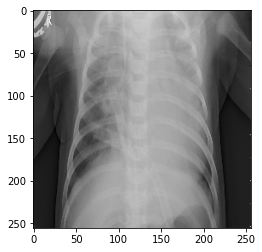

In [45]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [38]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,3])

IndexError: index 3 is out of bounds for axis 2 with size 3

In [46]:
model.evaluate(test_generator)

21/21 [==============================] - 3s 144ms/step - loss: 0.3358 - accuracy: 0.8680


[0.33575883507728577, 0.8680124282836914]

In [40]:
print("Test pneumonia cases: ", len(df_test[df_test['label'] == 1]))
print("Test normal cases: ", len(df_test[df_test['label'] == 0]))

Test pneumonia cases:  408
Test normal cases:  226


## Detail eval

In [47]:
predictions = model.predict(test_generator)

In [48]:
y_true = test_generator.df.label # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [49]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")

In [50]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [51]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[179  55]
 [ 30 380]]


In [52]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.86      0.76      0.81       234
   PNEUMONIA       0.87      0.93      0.90       410

    accuracy                           0.87       644
   macro avg       0.87      0.85      0.85       644
weighted avg       0.87      0.87      0.87       644



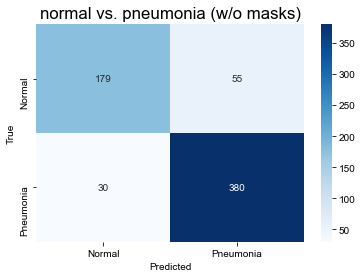

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
sns.set(font_scale=1.4)

# labels, title and ticks
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('normal vs. pneumonia (w/o masks)'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);

In [54]:
# get one test image
# we will leave this in a DataFrame i.o. to use our testgenerator logic
df_heat = df_test[df_test['label3'] == 'covid19'][1:2]
df_heat.reset_index(inplace=True)

In [55]:
df_heat

,index,img,label,mask,label2,label3
0,89,/home/8cb7/.kaggle/covid-chestxray-dataset/output/16745_5_1.png,1,/home/8cb7/.kaggle/covid-chestxray-dataset/masks//16745_5_1_predmask.jpg,virus,covid19


In [56]:
heat_test_generator = TrainDataGenerator4Channels(df_heat, False, IMG_SIZE, batch_size=1, shuffle=False, useMasks=USE_MASKS)

In [57]:
act_img = heat_test_generator.__getitem__(0)[0][0]

TypeError: Invalid shape (256, 256, 2) for image data

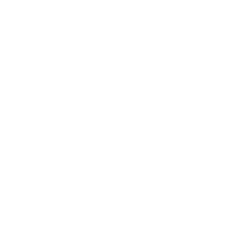

In [58]:
plt.grid(b=None)
plt.axis('off')
plt.imshow(act_img)

In [57]:
act_img = act_img.reshape(1, IMG_SIZE,IMG_SIZE, CHANNELS)

In [58]:
from keract import *
activations = get_activations(model, act_img, auto_compile=True, layer_names=['cb0_conv0', 'cb1_conv2'])

In [59]:
len(activations)

2

cb0_conv0 (1, 256, 256, 32) 


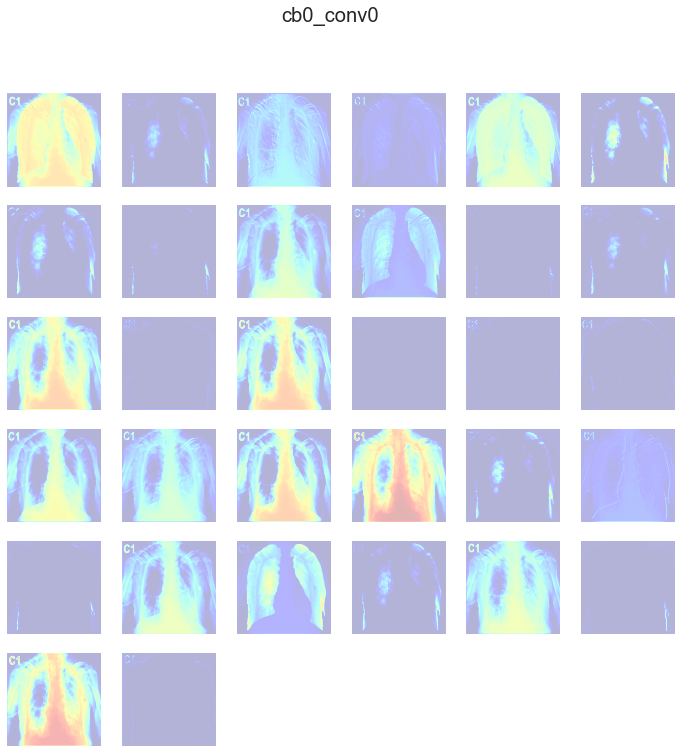

cb1_conv2 (1, 43, 43, 64) 


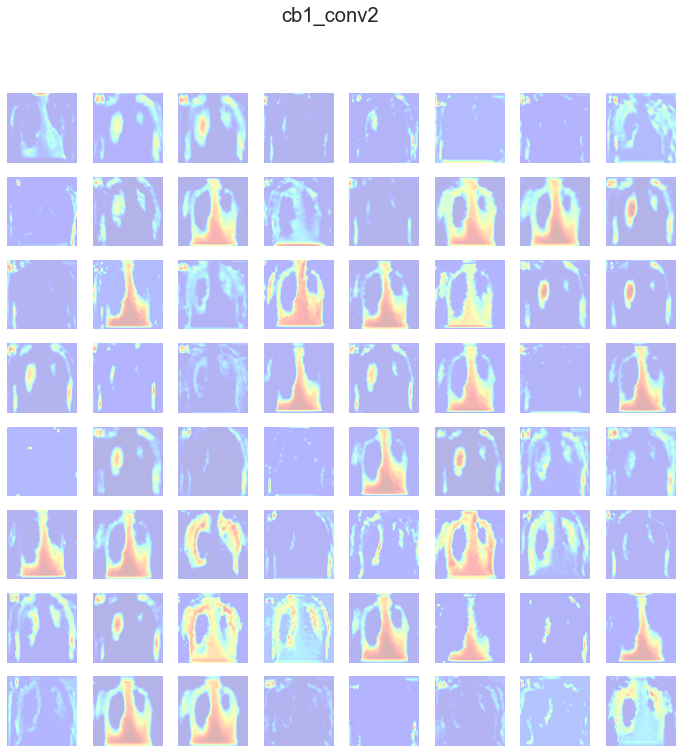

In [60]:
keract.display_heatmaps(activations, act_img, save=False, fix=True)